# Differential imaging of averaged iSCAT frames    

## Previously on PiSCAT tutorials...
In the last tutorial, we [set up the PiSCAT modules and downloaded a demo iSCAT video](Tutorial1.ipynb#Setting-up-the-PiSCAT-modules-and-downloading-a-demo-iSCAT-video), [did some basic checks on the acquisition process](Tutorial1.ipynb#Examining-the-status-line-&-removing-it), [suppressed the temporal instability of the laser light](Tutorial1.ipynb#Normalization-of-the-power-in-the-frames-of-a-video) and used some of the [basic data visualization](Tutorial1.ipynb#Display-and-inspect-a-loaded-video) tools provided in PiSCAT for inspection of the iSCAT videos.  

In [1]:
# Only to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Setting up the path to the PiSCAT modules
import os
import sys
current_path = os.path.abspath(os.path.join('..'))
dir_path = os.path.dirname(current_path)
module_path = os.path.join(dir_path)
if module_path not in sys.path:
    sys.path.append(module_path)

# Downloading a control video for this tutorial 
from piscat.InputOutput import download_tutorial_data
download_tutorial_data('control_video')

# Examining the status line in a loaded/downloaded video and removing the line
from piscat.InputOutput import reading_videos
from piscat.Visualization import JupyterDisplay
from piscat.InputOutput import read_status_line
from piscat.Preproccessing import normalization
import numpy as np

data_path = os.path.join(dir_path, 'Tutorials', 'Demo data')#The path to the demo data
df_video = reading_videos.DirectoryType(data_path, type_file='raw').return_df()
paths = df_video['Directory'].tolist()
video_names = df_video['File'].tolist()
demo_video_path = os.path.join(paths[0], video_names[0])#Selecting the first entry in the list
video = reading_videos.video_reader(file_name=demo_video_path, type='binary', img_width=128, img_height=128, 
                                    image_type=np.dtype('<u2'), s_frame=0, e_frame=-1)#Loading the video
status_ = read_status_line.StatusLine(video)#Reading the status line
video_remove_status, status_information  = status_.find_status_line()#Examining the status line & removing it

# Normalization of the power in the frames of a video
video_pn, _ = normalization.Normalization(video=video_remove_status).power_normalized()


The directory with the name  Demo data  already exists in the following path: F:\PiSCAT_GitHub_public\PiSCAT\Tutorials

The data file named  Control  already exists in the following path: F:\PiSCAT_GitHub_public\PiSCAT\Tutorials\Demo data
---Status line detected in column---

start power_normalized without parallel loop---> Done


## Frame averaging to boost SNR of imaged proteins, followed by visualization of their signal via differential imaging
The illumination profile and imaged speckles from the coverglass are among static features in iSCAT videos that can be removed by subtracting two subsequent frames to obtain a differential image which will only include dynamic features. As illustrated in the figure below, these features are new relative to the reference image, which is itself being rolled forward. In the calculation of the differential image, each image is the mean frame of a batch of $L$ number of camera frames. In order to apply Differential Rolling Average (DRA), an object of the class [Differential_Rolling_Average](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.BackgroundCorrection.DifferentialRollingAverage) is instantiated and deployed.

<img src="Fig/DRA.png" width="900">

In [2]:
#For Jupyter notebooks only:
%matplotlib inline

from piscat.BackgroundCorrection import DifferentialRollingAverage
DRA_PN = DifferentialRollingAverage(video=video_pn, batchSize=200)
RVideo_PN = DRA_PN.differential_rolling(FFT_flag=False)

from piscat.Visualization import JupyterDisplay
JupyterDisplay(RVideo_PN, median_filter_flag=False, color='gray', imgSizex=5, imgSizey=5, IntSlider_width='500px', step=100)


--- start DRA ---


  0%|          | 0/4598 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=10, continuous_update=False, description='Frame:', layout=Layout(width='…

## The effect of power normalization on the detection limit 
Here, we perform a quantitative analysis of the influence of the laser power fluctuations on the sensitivity limit of our scheme using [noise_floor class](https://piscat.readthedocs.io/en/latest/code_reference.html#piscat.BackgroundCorrection.NoiseFloor) to analyze the noise floor trend as a function of the batch size.

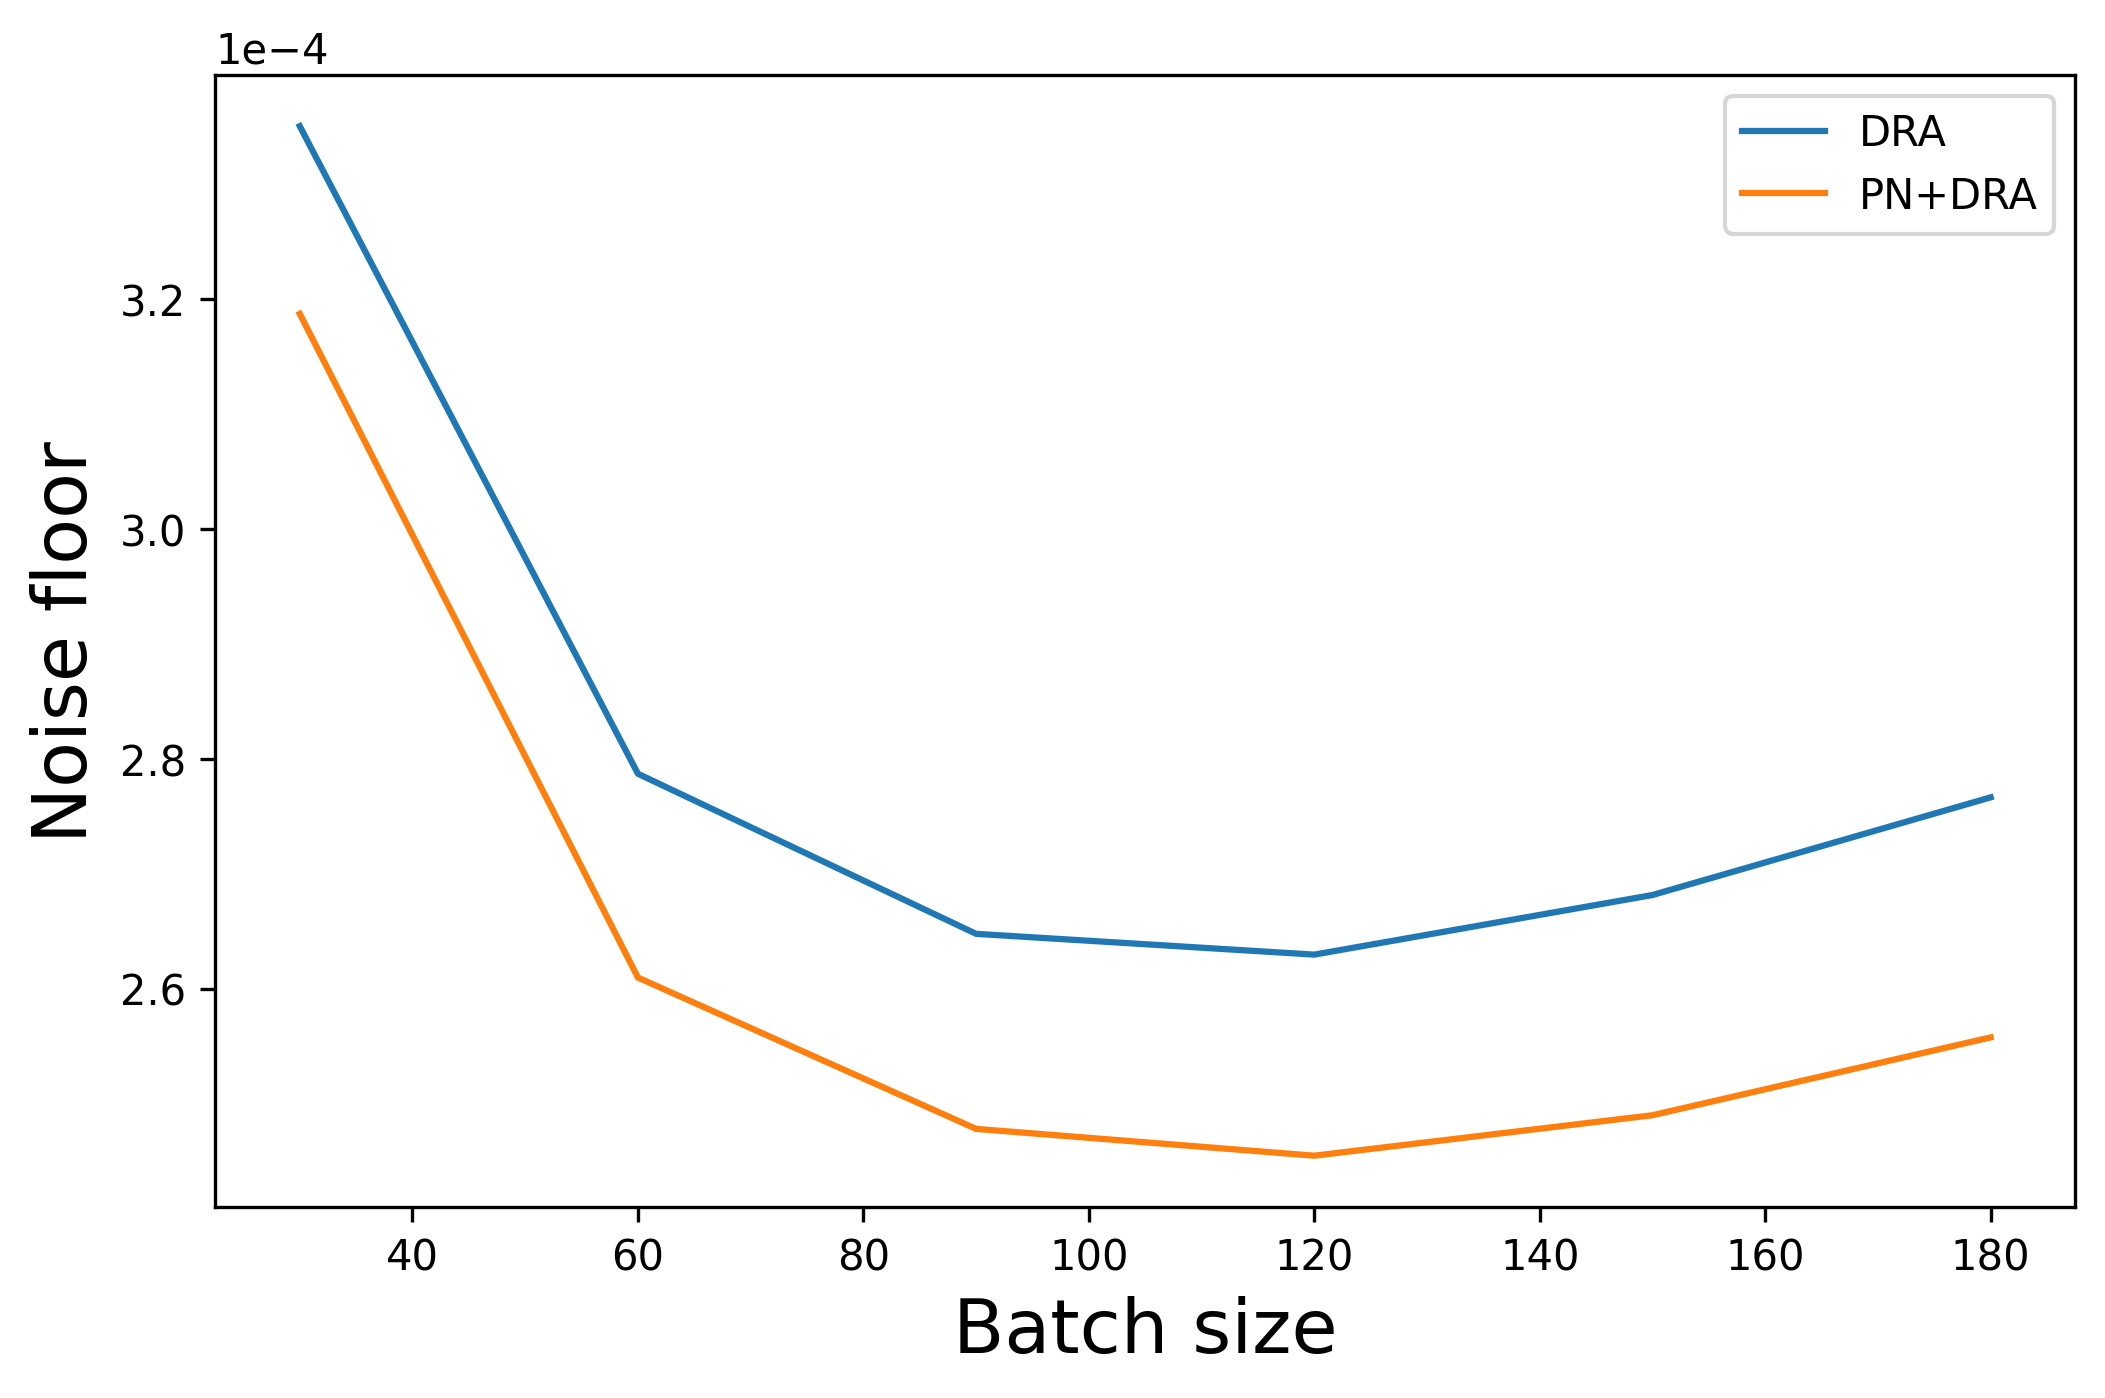

In [3]:
# Noise floor analysis

from piscat.BackgroundCorrection import NoiseFloor
l_range = list(range(30, 200, 30))
noise_floor_DRA = NoiseFloor(video_remove_status, list_range=l_range)
noise_floor_DRA_pn = NoiseFloor(video_pn, list_range=l_range)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 5), dpi=300)
plt.plot(l_range, noise_floor_DRA.mean, label='DRA')
plt.plot(l_range, noise_floor_DRA_pn.mean, label='PN+DRA')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.xlabel("Batch size", fontsize=18)
plt.ylabel("Noise floor", fontsize=18)
plt.legend()
plt.show()

We see about 10% improvement in our detection limit with performing power normalization on top of the differential rolling averaging with the best results obtained when the batch size corresponds to 120 frames.